In [1]:
import os
import json
import random
from tqdm import tqdm
import time
import psutil
import gc
import numpy as np
from tabulate import tabulate
from PIL import Image
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import torch
import torch.nn as nn
from torchvision.ops import box_iou
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models.detection import fasterrcnn_mobilenet_v3_large_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch_geometric.nn import GATConv
from torch_geometric.data import Data as GraphData
from torch_geometric.utils import dense_to_sparse
from pynvml import nvmlInit, nvmlDeviceGetHandleByIndex, nvmlDeviceGetMemoryInfo, nvmlShutdown
from codecarbon import EmissionsTracker

In [2]:
def set_seed(seed: int = 42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % (2**32)
    np.random.seed(worker_seed)
    random.seed(worker_seed)

In [3]:
final_output_json='../../data/processed/final_annotations_without_occluded.json'
image_directory = '../../data/images'

test_ratio = 0.2
valid_ratio = 0.1
random_seed = 42

with open(final_output_json, 'r') as f:
    annotations = json.load(f)

image_filenames = list(annotations['images'].keys())[:100]

random.seed(random_seed)
random.shuffle(image_filenames)

num_test = int(len(image_filenames) * test_ratio)
test_images = image_filenames[:num_test]
train_images = image_filenames[num_test:]
num_valid = int(len(train_images) * valid_ratio)
valid_images = train_images[:num_valid]

train_annotations = {
    'all_parts': annotations['all_parts'],
    'images': {img_name: annotations['images'][img_name] for img_name in train_images}
}

valid_annotations = {
    'all_parts': annotations['all_parts'],
    'images': {img_name: annotations['images'][img_name] for img_name in valid_images}
}

test_annotations = {
    'all_parts': annotations['all_parts'],
    'images': {img_name: annotations['images'][img_name] for img_name in test_images}
}


In [4]:
class BikePartsDetectionDataset(Dataset):
    def __init__(self, annotations_dict, image_dir, transform=None, augment=True, target_size=(640, 640)):
        self.all_parts = annotations_dict['all_parts']
        self.part_to_idx = {part: idx + 1 for idx, part in enumerate(self.all_parts)}
        self.idx_to_part = {idx + 1: part for idx, part in enumerate(self.all_parts)}
        self.image_data = annotations_dict['images']
        assert isinstance(self.image_data, dict), f"Expected dict, got {type(self.image_data)}"
        self.image_filenames = list(self.image_data.keys())

        self.image_dir = image_dir
        self.transform = transform
        self.augment = augment
        self.target_size = target_size

    def __len__(self):
        return len(self.image_filenames) * (2 if self.augment else 1)

    def apply_augmentation(self, image, boxes):
        if random.random() < 0.5:
            image = transforms.functional.hflip(image)
            w = image.width
            boxes = boxes.clone()
            boxes[:, [0, 2]] = w - boxes[:, [2, 0]]

        if random.random() < 0.8:
            image = transforms.functional.adjust_brightness(image, brightness_factor=random.uniform(0.6, 1.4))
        if random.random() < 0.8:
            image = transforms.functional.adjust_contrast(image, contrast_factor=random.uniform(0.6, 1.4))
        if random.random() < 0.5:
            image = transforms.functional.adjust_saturation(image, saturation_factor=random.uniform(0.7, 1.3))

        return image, boxes

    def __getitem__(self, idx):
        real_idx = idx % len(self.image_filenames)
        do_augment = self.augment and (idx >= len(self.image_filenames))

        img_filename = self.image_filenames[real_idx]
        img_path = os.path.join(self.image_dir, img_filename)

        image = Image.open(img_path).convert('RGB')
        orig_width, orig_height = image.size

        annotation = self.image_data[img_filename]
        available_parts_info = annotation['available_parts']
        missing_parts_names = annotation.get('missing_parts', [])

        boxes = []
        labels = []

        for part_info in available_parts_info:
            part_name = part_info['part_name']
            bbox = part_info['absolute_bounding_box']
            xmin = bbox['left']
            ymin = bbox['top']
            xmax = xmin + bbox['width']
            ymax = ymin + bbox['height']
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(self.part_to_idx[part_name])

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        if do_augment:
            image, boxes = self.apply_augmentation(image, boxes)

        image = transforms.functional.resize(image, self.target_size)
        new_width, new_height = self.target_size
        scale_x = new_width / orig_width
        scale_y = new_height / orig_height
        boxes[:, [0, 2]] *= scale_x
        boxes[:, [1, 3]] *= scale_y

        image = transforms.functional.to_tensor(image)

        missing_labels = torch.tensor(
            [self.part_to_idx[part] for part in missing_parts_names],
            dtype=torch.int64
        )

        target = {
            'boxes': boxes,
            'labels': labels,
            'missing_labels': missing_labels,
            'image_id': torch.tensor([real_idx])
        }

        return image, target

In [5]:
train_dataset = BikePartsDetectionDataset(
    annotations_dict=train_annotations,
    image_dir=image_directory,
    augment=False
)

valid_dataset = BikePartsDetectionDataset(
    annotations_dict=valid_annotations,
    image_dir=image_directory,
    augment=False
)

test_dataset = BikePartsDetectionDataset(
    annotations_dict=test_annotations,
    image_dir=image_directory,
    augment=False
)

train_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=4,
    collate_fn=lambda batch: tuple(zip(*batch))
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    collate_fn=lambda batch: tuple(zip(*batch))
)

test_loader = DataLoader(
    test_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    collate_fn=lambda batch: tuple(zip(*batch))
)

In [6]:
def evaluate_model(model, data_loader, part_to_idx, device):
    model.eval()

    all_parts_set = set(part_to_idx.values())
    results_per_image = []

    for images, targets in tqdm(data_loader, desc="Evaluating"):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        with torch.no_grad():
            predictions = model(images)

        for i in range(len(images)):
            pred_parts = set(predictions[i]['labels'].cpu().numpy().tolist())
            true_missing_parts = set(targets[i]['missing_labels'].cpu().numpy().tolist())
            image_id = targets[i]['image_id'].item()

            predicted_missing_parts = all_parts_set - pred_parts

            results_per_image.append({
                'image_id': image_id,
                'predicted_missing_parts': predicted_missing_parts,
                'true_missing_parts': true_missing_parts
            })

    return results_per_image


def part_level_evaluation(results, part_to_idx, idx_to_part):
    parts = list(part_to_idx.values())

    Y_true = np.array([[1 if p in r['true_missing_parts'] else 0 for p in parts] for r in results])
    Y_pred = np.array([[1 if p in r['predicted_missing_parts'] else 0 for p in parts] for r in results])

    micro_f1 = f1_score(Y_true, Y_pred, average='micro', zero_division=0)
    macro_f1 = f1_score(Y_true, Y_pred, average='macro', zero_division=0)

    FN = np.logical_and(Y_true==1, Y_pred==0).sum()
    TP = np.logical_and(Y_true==1, Y_pred==1).sum()
    FP = np.logical_and(Y_true==0, Y_pred==1).sum()

    N_images = len(results)
    miss_rate = FN/(FN+TP) if (FN+TP)>0 else 0
    fppi = FP/N_images

    overall_acc = accuracy_score(Y_true.flatten(), Y_pred.flatten())
    overall_prec = precision_score(Y_true.flatten(), Y_pred.flatten(), zero_division=0)
    overall_rec = recall_score(Y_true.flatten(), Y_pred.flatten(), zero_division=0)
    overall_f1 = f1_score(Y_true.flatten(), Y_pred.flatten(), zero_division=0)
    print(f"Micro-F1: {micro_f1:.4f}, Macro-F1: {macro_f1:.4f}")
    print(f"Miss Rate: {miss_rate:.4f}, FPPI: {fppi:.4f}")
    print(f"Overall Acc: {overall_acc:.4f}, Precision: {overall_prec:.4f}, Recall: {overall_rec:.4f}, F1: {overall_f1:.4f}")
    
    table=[]
    for j,p in enumerate(parts):
        acc = accuracy_score(Y_true[:,j], Y_pred[:,j])
        prec = precision_score(Y_true[:,j], Y_pred[:,j], zero_division=0)
        rec = recall_score(Y_true[:,j], Y_pred[:,j], zero_division=0)
        f1s = f1_score(Y_true[:,j], Y_pred[:,j], zero_division=0)
        table.append([idx_to_part[p], f"{acc:.3f}", f"{prec:.3f}", f"{rec:.3f}", f"{f1s:.3f}"])
    print(tabulate(table, headers=["Part","Acc","Prec","Rec","F1"], tablefmt="fancy_grid"))


In [ ]:
detector = fasterrcnn_mobilenet_v3_large_fpn(weights="DEFAULT")
in_feats = detector.roi_heads.box_predictor.cls_score.in_features

detector.roi_heads.box_predictor = FastRCNNPredictor(in_feats, len(train_dataset.all_parts)+1)

class RelationProposalNetwork(nn.Module):
    def __init__(self, in_c, hidden_c=256):
        super().__init__()
        self.fc1 = nn.Linear(in_c*2 + 4, hidden_c)
        self.fc2 = nn.Linear(hidden_c, 1)
    def forward(self, feats, boxes):
        N, C = feats.size()
        f1 = feats.unsqueeze(1).expand(-1, N, -1)
        f2 = feats.unsqueeze(0).expand(N, -1, -1)
        b1 = boxes.unsqueeze(1).expand(-1, N, -1)
        b2 = boxes.unsqueeze(0).expand(N, -1, -1)
        geom = torch.abs(b1 - b2)
        x = torch.relu(self.fc1(torch.cat([f1, f2, geom], dim=-1)))
        return torch.sigmoid(self.fc2(x)).squeeze(-1)

class AttentionalGCN(nn.Module):
    def __init__(self, in_c, hid_c, out_c, heads=4):
        super().__init__()
        self.gat1 = GATConv(in_c, hid_c, heads=heads)
        self.gat2 = GATConv(hid_c*heads, out_c, heads=1)
    def forward(self, x, edge_index):
        x = torch.relu(self.gat1(x, edge_index))
        return self.gat2(x, edge_index)

class GraphRCNN(nn.Module):
    def __init__(self, detector, num_classes, k=3):
        super().__init__()
        self.detector = detector
        self.repn = RelationProposalNetwork(in_feats)
        self.agcn = AttentionalGCN(in_feats + 4, 256, num_classes)
        self.k = k

    def forward(self, images, targets=None):
        if self.training:
            loss_dict = self.detector(images, targets)

            total_loss = sum(loss for loss in loss_dict.values())

            rpn_loss = self.compute_rpn_loss(images, targets)
            gcn_loss, repnet_loss = self.compute_gcn_loss(images, targets)

            loss_dict.update({
                "rpn_loss": rpn_loss,
                "gcn_loss": gcn_loss,
                "repnet_loss": repnet_loss
            })
            total_loss = rpn_loss + gcn_loss + repnet_loss

            return total_loss, loss_dict

        dets = self.detector(images)
        outs = []
        for img, det in zip(images, dets):
            boxes = det['boxes']
            if boxes.numel() == 0:
                outs.append(det)
                continue

            feats = self._get_roi_feats(img.unsqueeze(0), boxes)
            rel = self.repn(feats, boxes)
            edge_idx = self._make_edge_index(rel)
            geom = self._box_geom(boxes, img.shape[-2:])
            node_feats = torch.cat([feats, geom], dim=1)
            logits = self.agcn(node_feats, edge_idx)
            det['labels'] = torch.argmax(logits, 1)
            det['scores'] = torch.softmax(logits, 1).max(1).values
            outs.append(det)

        return outs

    def _get_roi_feats(self, img, boxes):
        fmap = self.detector.backbone(img)
        roi = self.detector.roi_heads.box_roi_pool(fmap, [boxes], [img.shape[-2:]])
        return self.detector.roi_heads.box_head(roi)

    def _make_edge_index(self, scores):
        idx = torch.topk(scores, self.k + 1, dim=1).indices[:, 1:]
        src = idx.flatten()
        dst = torch.arange(scores.size(0), device=scores.device).unsqueeze(1).expand(-1, self.k).flatten()
        return torch.stack([dst, src], 0)

    def _box_geom(self, boxes, shape):
        h, w = shape
        nb = boxes.clone()
        nb[:, [0, 2]] /= w
        nb[:, [1, 3]] /= h
        return torch.stack([nb[:, 0], nb[:, 1], nb[:, 2] - nb[:, 0], nb[:, 3] - nb[:, 1]], 1)

    def compute_rpn_loss(self, images, targets):
        images_transformed, targets_transformed = self.detector.transform(images, targets)

        features = self.detector.backbone(images_transformed.tensors)

        proposals, rpn_losses = self.detector.rpn(images_transformed, features, targets_transformed)

        rpn_loss = sum(rpn_losses.values())

        return rpn_loss


    def compute_gcn_loss(self, images, targets):
        gcn_preds = []
        gcn_labels = []
        total_repnet_loss = 0.0

        for img, target in zip(images, targets):
            boxes = target['boxes']
            labels = target['labels']

            if boxes.numel() == 0:
                continue

            feats = self._get_roi_feats(img.unsqueeze(0), boxes)
            rel = self.repn(feats, boxes)
            edge_idx = self._make_edge_index(rel)

            geom = self._box_geom(boxes, img.shape[-2:])
            node_feats = torch.cat([feats, geom], dim=1)
            logits = self.agcn(node_feats, edge_idx)

            gcn_preds.append(logits)
            gcn_labels.append(labels)

            repnet_loss = self.compute_repnet_loss(feats, boxes)
            total_repnet_loss += repnet_loss

        if not gcn_preds:
            return torch.tensor(0.0, device=images[0].device), torch.tensor(0.0, device=images[0].device)

        gcn_preds = torch.cat(gcn_preds)
        gcn_labels = torch.cat(gcn_labels)
        gcn_loss = nn.functional.cross_entropy(gcn_preds, gcn_labels)

        return gcn_loss, total_repnet_loss

    
    def compute_repnet_loss(self, feats, boxes):
        N = boxes.size(0)
        if N < 2:
            return torch.tensor(0.0, device=feats.device)

        rel_scores = self.repn(feats, boxes)

        with torch.no_grad():
            iou = box_iou(boxes, boxes)
            target_rel = (iou > 0.1).float()

            target_rel.fill_diagonal_(0)

        loss = nn.functional.binary_cross_entropy(rel_scores, target_rel)
        return loss



In [ ]:
# import torch
# import matplotlib.pyplot as plt
# import torchvision.transforms.functional as F
# import seaborn as sns
# import networkx as nx

# def visualize_detections(image_tensor, detections, all_parts, threshold=0.5):
#     image_np = F.to_pil_image(image_tensor.cpu())
#     plt.imshow(image_np)
#     ax = plt.gca()

#     for box, score, label in zip(detections['boxes'], detections['scores'], detections['labels']):
#         if score < threshold:
#             continue
#         box = box.detach().cpu().numpy()
#         label_name = all_parts[label.item()-1] if label.item() > 0 else "background"
#         ax.add_patch(plt.Rectangle((box[0], box[1]),
#                                    box[2]-box[0], box[3]-box[1],
#                                    fill=False, edgecolor='red', linewidth=2))
#         ax.text(box[0], box[1], f"{label_name}: {score:.2f}", color='white',
#                 fontsize=10, bbox=dict(facecolor='red', alpha=0.5))
#     plt.axis('off')

# def visualize_graph(boxes, edge_index, image_tensor=None):
#     G = nx.DiGraph()
#     positions = {}

#     boxes = boxes.detach().cpu().numpy()
#     edge_index = edge_index.detach().cpu().numpy()

#     for i, box in enumerate(boxes):
#         cx = (box[0] + box[2]) / 2
#         cy = (box[1] + box[3]) / 2
#         G.add_node(i)
#         positions[i] = (cx, cy)

#     for src, dst in zip(edge_index[0], edge_index[1]):
#         G.add_edge(src, dst)

#     if image_tensor is not None:
#         img = F.to_pil_image(image_tensor.cpu())
#         plt.imshow(img)

#     nx.draw(G, pos=positions, with_labels=True, node_color='lightblue', edge_color='gray')
#     plt.axis('off')

# def visualize_relation_matrix(scores):
#     scores = scores.detach().cpu().numpy()
#     sns.heatmap(scores, cmap='viridis', xticklabels=False, yticklabels=False)
#     plt.title("Relation Proposal Scores")
#     plt.xlabel("To Node")
#     plt.ylabel("From Node")

# def run_visualization_dashboard(model, data_loader, all_parts, batch_idx=0, score_threshold=0.5):
#     model.eval()
#     with torch.no_grad():
#         for batch_i, (images, targets) in enumerate(data_loader):
#             if batch_i != batch_idx:
#                 continue

#             outputs = model(images)
#             for i, (img, det) in enumerate(zip(images, outputs)):
#                 print(f"Image {i+1}/{len(images)}")import torch
# import matplotlib.pyplot as plt
# import torchvision.transforms.functional as F
# import seaborn as sns
# import networkx as nx

# def visualize_detections(image_tensor, detections, all_parts, threshold=0.5):
#     image_np = F.to_pil_image(image_tensor.cpu())
#     plt.imshow(image_np)
#     ax = plt.gca()

#     for box, score, label in zip(detections['boxes'], detections['scores'], detections['labels']):
#         if score < threshold:
#             continue
#         box = box.detach().cpu().numpy()
#         label_name = all_parts[label.item()-1] if label.item() > 0 else "background"
#         ax.add_patch(plt.Rectangle((box[0], box[1]),
#                                    box[2]-box[0], box[3]-box[1],
#                                    fill=False, edgecolor='red', linewidth=2))
#         ax.text(box[0], box[1], f"{label_name}: {score:.2f}", color='white',
#                 fontsize=10, bbox=dict(facecolor='red', alpha=0.5))
#     plt.axis('off')

# def visualize_graph(boxes, edge_index, image_tensor=None):
#     G = nx.DiGraph()
#     positions = {}

#     boxes = boxes.detach().cpu().numpy()
#     edge_index = edge_index.detach().cpu().numpy()

#     for i, box in enumerate(boxes):
#         cx = (box[0] + box[2]) / 2
#         cy = (box[1] + box[3]) / 2
#         G.add_node(i)
#         positions[i] = (cx, cy)

#     for src, dst in zip(edge_index[0], edge_index[1]):
#         G.add_edge(src, dst)

#     if image_tensor is not None:
#         img = F.to_pil_image(image_tensor.cpu())
#         plt.imshow(img)

#     nx.draw(G, pos=positions, with_labels=True, node_color='lightblue', edge_color='gray')
#     plt.axis('off')

# def visualize_relation_matrix(scores):
#     scores = scores.detach().cpu().numpy()
#     sns.heatmap(scores, cmap='viridis', xticklabels=False, yticklabels=False)
#     plt.title("Relation Proposal Scores")
#     plt.xlabel("To Node")
#     plt.ylabel("From Node")

# def run_visualization_dashboard(model, data_loader, all_parts, batch_idx=0, score_threshold=0.5):
#     model.eval()
#     with torch.no_grad():
#         for batch_i, (images, targets) in enumerate(data_loader):
#             if batch_i != batch_idx:
#                 continue

#             outputs = model(images)
#             for i, (img, det) in enumerate(zip(images, outputs)):
#                 print(f"Image {i+1}/{len(images)}")
#                 plt.figure(figsize=(16, 5))

#                 # 1. Detection Visualization
#                 plt.subplot(1, 3, 1)
#                 visualize_detections(img, det, all_parts, threshold=score_threshold)
#                 plt.title("Detections")

#                 # 2. Relation Graph (only if >1 box)
#                 if det['boxes'].size(0) > 1:
#                     feats = model._get_roi_feats(img.unsqueeze(0), det['boxes'])
#                     rel_scores = model.repn(feats, det['boxes'])
#                     edge_index = model._make_edge_index(rel_scores)

#                     plt.subplot(1, 3, 2)
#                     visualize_graph(det['boxes'], edge_index, img)
#                     plt.title("Relation Graph")

#                     # 3. Relation Matrix
#                     plt.subplot(1, 3, 3)
#                     visualize_relation_matrix(rel_scores)
#                 else:
#                     plt.subplot(1, 3, 2)
#                     plt.text(0.5, 0.5, "Not enough detections for graph", ha='center', va='center')
#                     plt.axis('off')

#                 plt.tight_layout()
#                 plt.show()

#             break

#                 plt.figure(figsize=(16, 5))

#                 # 1. Detection Visualization
#                 plt.subplot(1, 3, 1)
#                 visualize_detections(img, det, all_parts, threshold=score_threshold)
#                 plt.title("Detections")

#                 # 2. Relation Graph (only if >1 box)
#                 if det['boxes'].size(0) > 1:
#                     feats = model._get_roi_feats(img.unsqueeze(0), det['boxes'])
#                     rel_scores = model.repn(feats, det['boxes'])
#                     edge_index = model._make_edge_index(rel_scores)

#                     plt.subplot(1, 3, 2)
#                     visualize_graph(det['boxes'], edge_index, img)
#                     plt.title("Relation Graph")

#                     # 3. Relation Matrix
#                     plt.subplot(1, 3, 3)
#                     visualize_relation_matrix(rel_scores)
#                 else:
#                     plt.subplot(1, 3, 2)
#                     plt.text(0.5, 0.5, "Not enough detections for graph", ha='center', va='center')
#                     plt.axis('off')

#                 plt.tight_layout()
#                 plt.show()

#             break


[codecarbon WARNING @ 23:15:33] Multiple instances of codecarbon are allowed to run at the same time.
Epoch 1/1: 100%|██████████| 20/20 [01:59<00:00,  5.96s/batch, loss=2.7013, time (s)=5.419, GPU Mem (MB)=0, CPU Mem (MB)=11485]


+-------------------------------+------------+
|            Metric             |   Value    |
+-------------------------------+------------+
|             Epoch             |     1      |
|          Final Loss           |   2.7013   |
|   Average Batch Time (sec)    |   5.6737   |
| Average GPU Memory Usage (MB) |    0.00    |
| Average CPU Memory Usage (MB) |  11723.59  |
|   Energy Consumption (kWh)    | 0.0006 kWh |
|      CO₂ Emissions (kg)       | 0.0002 kg  |
+-------------------------------+------------+
Image 1/4


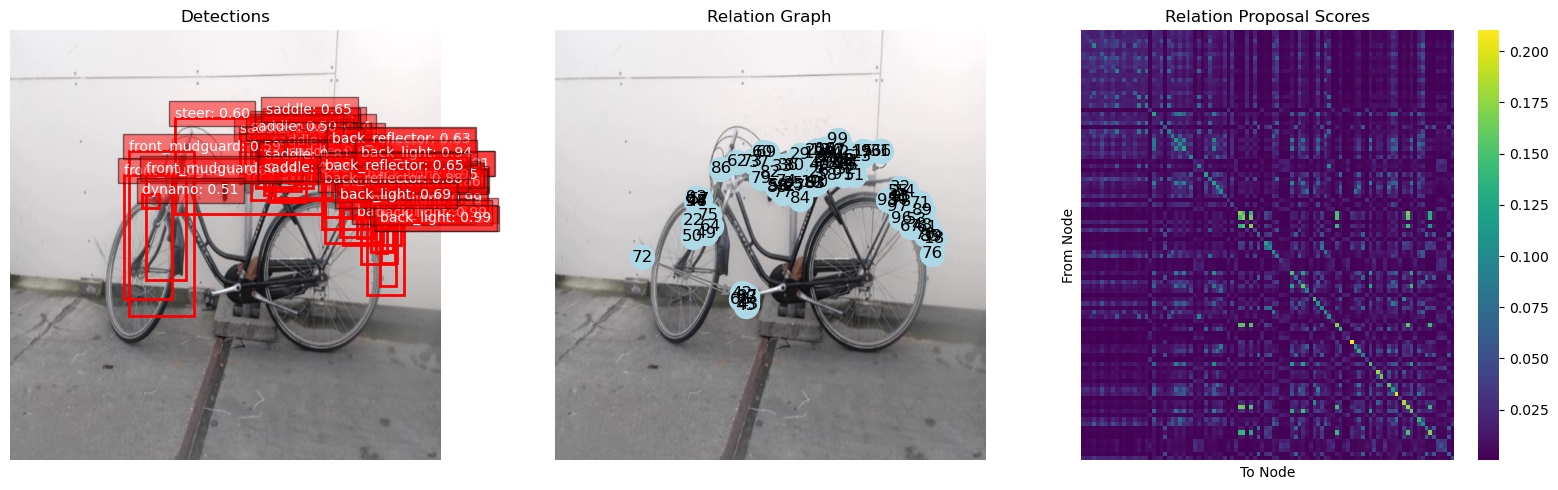

Image 2/4


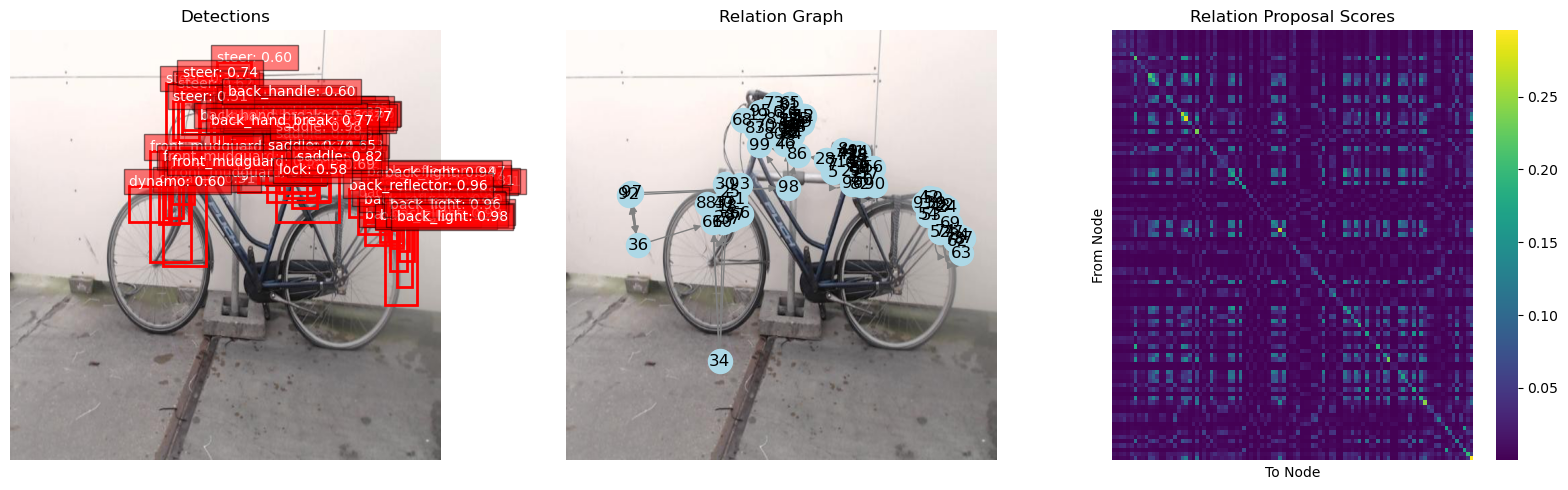

Image 3/4


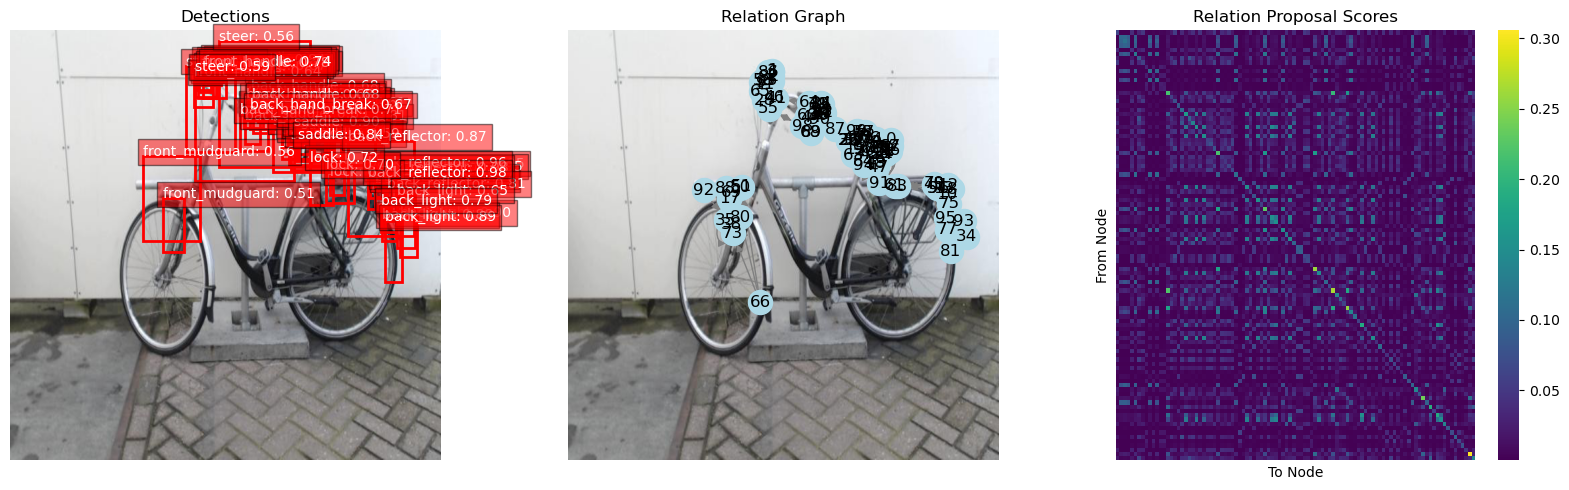

Image 4/4


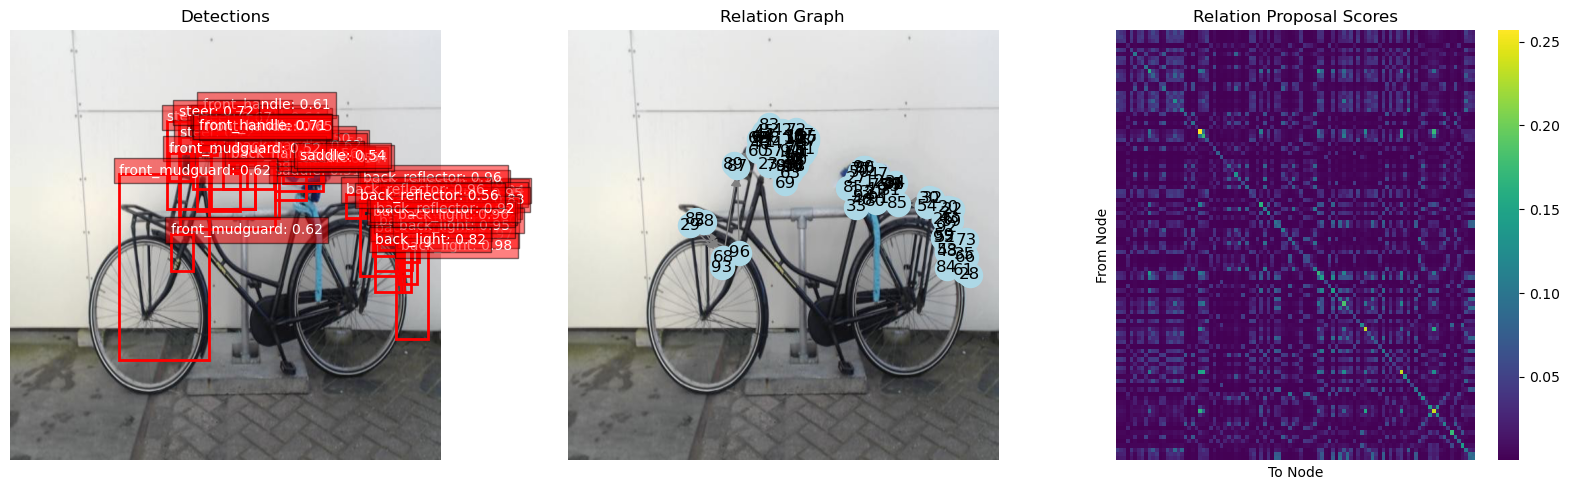


Evaluating on validation set after Epoch 1...


Evaluating: 100%|██████████| 2/2 [00:08<00:00,  4.47s/it]


Saved new best model (macro-F1: 0.3717)


In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GraphRCNN(detector, len(train_dataset.all_parts) + 1).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

if torch.cuda.is_available():
    nvmlInit()
    handle = nvmlDeviceGetHandleByIndex(0)

num_epochs = 1
freeze_epoch = 1
best_macro_f1 = 0
epochs_without_improvement = 0
patience = 3

for epoch in range(num_epochs):

    if epoch == freeze_epoch:
        print(f"Freezing detector backbone and ROI heads at epoch {epoch}")
        
        for param in model.detector.backbone.parameters():
            param.requires_grad = False
        
        for param in model.detector.roi_heads.parameters():
            param.requires_grad = False

    with EmissionsTracker(log_level="critical", save_to_file=False) as tracker:

        model.train()

        batch_times = []
        gpu_memories = []
        cpu_memories = []

        with tqdm(train_loader, unit="batch", desc=f"Epoch {epoch + 1}/{num_epochs}") as tepoch:
            for images, targets in tepoch:
                start_time = time.time()

                images = [image.to(device) for image in images]
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

                total_loss, loss_dict = model(images, targets)
                # losses = sum(loss for loss in loss_dict.values())

                optimizer.zero_grad()
                total_loss.backward()
                optimizer.step()

                end_time = time.time()
                inference_time = end_time - start_time
                batch_times.append(inference_time)

                if torch.cuda.is_available():
                    mem_info = nvmlDeviceGetMemoryInfo(handle)
                    gpu_mem_used = mem_info.used / (1024 ** 2)
                    gpu_memories.append(gpu_mem_used)
                else:
                    gpu_mem_used = 0

                cpu_mem_used = psutil.virtual_memory().used / (1024 ** 2)
                cpu_memories.append(cpu_mem_used)

                tepoch.set_postfix({
                    "loss": f"{total_loss.item():.4f}",
                    "time (s)": f"{inference_time:.3f}",
                    "GPU Mem (MB)": f"{gpu_mem_used:.0f}",
                    "CPU Mem (MB)": f"{cpu_mem_used:.0f}"
                })

                gc.collect()
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()

    energy_consumption = tracker.final_emissions_data.energy_consumed
    co2_emissions = tracker.final_emissions

    avg_time = sum(batch_times) / len(batch_times)
    max_gpu_mem = max(gpu_memories) if gpu_memories else 0
    max_cpu_mem = max(cpu_memories)

    table = [
        ["Epoch", epoch + 1],
        ["Final Loss", f"{total_loss.item():.4f}"],
        ["Average Batch Time (sec)", f"{avg_time:.4f}"],
        ["Average GPU Memory Usage (MB)", f"{max_gpu_mem:.2f}"],
        ["Average CPU Memory Usage (MB)", f"{max_cpu_mem:.2f}"],
        ["Energy Consumption (kWh)", f"{energy_consumption:.4f} kWh"],
        ["CO₂ Emissions (kg)", f"{co2_emissions:.4f} kg"],
    ]

    print(tabulate(table, headers=["Metric", "Value"], tablefmt="pretty"))

    # # Evaluate on validation set
    # model.eval()
    # with torch.no_grad():
    #     run_visualization_dashboard(model, valid_loader, train_dataset.all_parts, batch_idx=0)
    # model.train()

    print(f"\nEvaluating on validation set after Epoch {epoch + 1}...")
    results_per_image = evaluate_model(model, valid_loader, train_dataset.part_to_idx, device)

    parts = list(train_dataset.part_to_idx.values())
    Y_true = np.array([[1 if p in r['true_missing_parts'] else 0 for p in parts] for r in results_per_image])
    Y_pred = np.array([[1 if p in r['predicted_missing_parts'] else 0 for p in parts] for r in results_per_image])
    macro_f1 = f1_score(Y_true, Y_pred, average='macro', zero_division=0)

    if macro_f1 > best_macro_f1:
        best_macro_f1 = macro_f1
        epochs_without_improvement = 0
        torch.save(model.state_dict(), f"../../models/graph_rcnn/graphrcnn_MobileNet_baseline_model.pth")
        print(f"Saved new best model (macro-F1: {macro_f1:.4f})")
    else:
        epochs_without_improvement += 1
        print(f"No improvement in macro-F1 for {epochs_without_improvement} epoch(s)")

        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered (no improvement for {patience} epochs)")
            break

if torch.cuda.is_available():
    nvmlShutdown()

In [10]:
model.load_state_dict(torch.load("../../models/graph_rcnn/graphrcnn_MobileNet_baseline_model.pth", map_location=device))
model.to(device)

results_per_image = evaluate_model(model, valid_loader, train_dataset.part_to_idx, device)

print(results_per_image)

part_level_evaluation(
    results_per_image, train_dataset.part_to_idx, train_dataset.idx_to_part
)


/tmp/ipykernel_41594/349410656.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("../../models/graph_rcnn/graphrcnn_MobileNet_baseline_mod

[{'image_id': 0, 'predicted_missing_parts': {2, 3, 5, 6, 7, 9, 10, 12, 13, 15, 17, 18}, 'true_missing_parts': {1, 2, 5, 9, 12, 13, 16, 18, 20, 22}}, {'image_id': 1, 'predicted_missing_parts': {1, 3, 5, 6, 7, 9, 10, 13, 15, 17, 18, 21}, 'true_missing_parts': {5, 9, 13, 18, 19, 22}}, {'image_id': 2, 'predicted_missing_parts': {1, 3, 5, 6, 7, 9, 10, 13, 17, 18, 21}, 'true_missing_parts': {5, 11, 13, 16, 18, 19}}, {'image_id': 3, 'predicted_missing_parts': {5, 6, 7, 9, 10, 11, 13, 17, 22}, 'true_missing_parts': {1, 2, 5, 7, 8, 9, 11, 13, 17, 19, 22}}, {'image_id': 4, 'predicted_missing_parts': {1, 3, 5, 6, 7, 9, 10, 13, 15, 17, 18, 21}, 'true_missing_parts': {2, 7, 9, 11, 17, 18, 21, 22}}, {'image_id': 5, 'predicted_missing_parts': {1, 3, 5, 6, 7, 9, 10, 13, 17, 18, 22}, 'true_missing_parts': {1, 5, 6, 9, 13, 14, 16, 19, 22}}, {'image_id': 6, 'predicted_missing_parts': {1, 3, 5, 6, 7, 9, 10, 12, 13, 15, 17, 18, 21}, 'true_missing_parts': {1, 9, 13, 18, 19}}, {'image_id': 7, 'predicted_miss